# DNN_PAPER_V2 regenerate all feature vectors for validation

## Import & Helperfunctions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
import math
from keras.utils.vis_utils import plot_model
import uuid

/home/spokencall/.conda/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/spokencall/.conda/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def clearY(y):
    clean_input = np.array([]).reshape(0, 1)
    for data in y:
        pos1 = data[0]
        pos2 = data[1]
        pos3 = data[2]
        if  pos1 == 1 and pos2 == 0 and pos3 ==0:
                clean_input = np.vstack((clean_input, [1]))
        else:
                clean_input = np.vstack((clean_input, [0]))
    return clean_input

In [3]:
def evaluate(true_y, pred_y):
    true_classes = []
    for array in true_y:
        if np.array_equal(array,[1, 0, 0]):
            true_classes.append(0)
        elif np.array_equal(array,[0, 1, 0]):
            true_classes.append(1)
        else:
            true_classes.append(2)
        
    CR, CA, PFA, GFA, FR, k = 0, 0, 0, 0, 0, 3.0
    for idx, prediction in enumerate(pred_y):
        # the students answer is correct in meaning and language
        # the system says the same -> accept
        if true_classes[idx] == 0 and prediction == 1:
            CA += 1
        # the system says correct meaning wrong language -> reject
        elif true_classes[idx] == 0 and prediction == 0:
            FR += 1
        # the system says incorrect meaning and incorrect language -> reject
        elif true_classes[idx] == 0 and prediction == 0:
            FR += 1

        # students answer is correct in meaning and wrong in language
        #The system says the same -> reject
        elif true_classes[idx] == 1 and prediction == 0:
            CR += 1
        # the system says correct meaning and correct language -> accept
        elif true_classes[idx] == 1 and prediction == 1:
            PFA += 1
        # the system says incorrect meaning and incorrect language -> reject
        elif true_classes[idx] == 1 and prediction == 0:
            CR += 1

        # students answer is incorrect in meaning and incorrect in language
        # the system says the same -> reject
        elif true_classes[idx] == 2 and prediction == 0:
            CR += 1
        # the system says correct meaning correct language -> accept
        elif true_classes[idx] == 2 and prediction == 1: 
            GFA += 1
        # the system says correct meaning incorrect language -> reject
        elif true_classes[idx] == 2 and prediction == 0:
            CR += 1

    FA = PFA + k * GFA
    Correct = CA + FR
    Incorrect = CR + GFA + PFA
    IncorrectRejectionRate = CR / ( CR + FA + 0.0 )
    CorrectRejectionRate = FR / ( FR + CA + 0.0 )
    # Further metrics
    Z = CA + CR + FA + FR
    Ca = CA / Z
    Cr = CR / Z
    Fa = FA / Z
    Fr = FR / Z
    
    P = Ca / (Ca + Fa)
    R = Ca / (Ca + Fr)
    F = (2 * P * R)/( P + R)
    
    RCa = Ca / (Fr + Ca)
    RFa = Fa / (Cr + Fa)
    
    D = IncorrectRejectionRate / CorrectRejectionRate
    Da = RCa / RFa
    Df = math.sqrt((Da*D))
    
    print('\nINCORRECT UTTERANCES (' + str(Incorrect) + ')' )
    print('CorrectReject    ' + str(CR) )
    print('GrossFalseAccept ' + str(GFA) + '*' + str(k) + ' = ' + str(GFA * k) )
    print('PlainFalseAccept ' + str(PFA) )
    print('RejectionRate    ' + "{:.3f}".format(IncorrectRejectionRate) )

    print('\nCORRECT UTTERANCES (' + str(Correct) + ')')
    print('CorrectAccept    ' + str(CA) )
    print('FalseReject      ' + str(FR) )
    print('RejectionRate    ' + "{:.3f}".format(CorrectRejectionRate) )
    
    print('\n--------------REPORT---------------')
    print('-----------------------------------')
    print('Pr                            ' +  "{:.3f}".format(P) )
    print('F                             ' +  "{:.3f}".format(F) )
    print('Sa                            ' +  "{:.3f}".format(R) )
    #print('R                             ' +  "{:.3f}".format(R) )

    
    print('\n--------------Metrics--------------')
    print('D                             ' +  "{:.3f}".format(D) )
    print('Da                            ' +  "{:.3f}".format(Da) )
    print('Df                            ' +  "{:.3f}".format(Df) )

## Preprocessing

In [4]:
train_x = np.loadtxt('/home/spokencall/dnnPaper/expValidation2/vec_train_x.csv' ,delimiter=',',usecols=range(11)[1:])
train_y = clearY(np.loadtxt('/home/spokencall/dnnPaper/expValidation2/vec_train_y.csv', delimiter=',',usecols=range(4)[1:]))

print('Train_x:    ' + str(len(train_x)))
print('Train_y:    ' + str(len(train_y)))

print('\n')


dev_test_x = np.loadtxt('/home/spokencall/dnnPaper/expValidation2/vec_test_x.csv', delimiter=',',usecols=range(11)[1:])
dev_test_y = np.loadtxt('/home/spokencall/dnnPaper/expValidation2/vec_test_y.csv', delimiter=',',usecols=range(4)[1:])
print('Dev_Test_x:    ' + str(len(dev_test_x)))
print('Dev_Test_y:    ' + str(len(dev_test_y)))

print('\n')

st2_test_x = np.loadtxt('/home/spokencall/dnnPaper/expValidation2/vec_st2_test_x.csv', delimiter=',',usecols=range(11)[1:])
st2_test_y = np.loadtxt('/home/spokencall/dnnPaper/expValidation2/vec_st2_test_y.csv', delimiter=',',usecols=range(4)[1:])
print('St2_Test_x:    ' + str(len(st2_test_x)))
print('St2_Test_y:    ' + str(len(st2_test_y)))

Train_x:    10092
Train_y:    10092


Dev_Test_x:    2524
Dev_Test_y:    2524


St2_Test_x:    1000
St2_Test_y:    1000


In [5]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [6]:
# Sclae the vectors inorder to get better classification
sc = StandardScaler()
scaled_train_x = sc.fit_transform(train_x)
scaled_dev_test_x = sc.transform(dev_test_x)
scaled_st2_test_x = sc.transform(st2_test_x)

## DNN definition

In [7]:
#Initializing Neural Network
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(64, activation='relu', input_dim=10))
classifier.add(Dropout(0.5))
classifier.add(Dense(64, activation='relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(1, activation='sigmoid'))

In [8]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
classifier.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

## Training of the model

In [10]:
# Fitting our model 
hist = classifier.fit(scaled_train_x, train_y, batch_size = 150, epochs = 600, validation_split=0.1)

Train on 9082 samples, validate on 1010 samples
Epoch 1/600
9082/9082 [==============================] - 0s 36us/step - loss: 0.5944 - acc: 0.7120 - val_loss: 0.5325 - val_acc: 0.7287
Epoch 2/600
9082/9082 [==============================] - 0s 24us/step - loss: 0.5258 - acc: 0.7470 - val_loss: 0.5079 - val_acc: 0.7396
Epoch 3/600
9082/9082 [==============================] - 0s 22us/step - loss: 0.4971 - acc: 0.7553 - val_loss: 0.4788 - val_acc: 0.7713
Epoch 4/600
9082/9082 [==============================] - 0s 23us/step - loss: 0.4627 - acc: 0.7777 - val_loss: 0.4482 - val_acc: 0.7861
Epoch 5/600
9082/9082 [==============================] - 0s 24us/step - loss: 0.4304 - acc: 0.8071 - val_loss: 0.4263 - val_acc: 0.8119
Epoch 6/600
9082/9082 [==============================] - 0s 24us/step - loss: 0.4025 - acc: 0.8324 - val_loss: 0.4171 - val_acc: 0.8218
Epoch 7/600
9082/9082 [==============================] - 0s 24us/step - loss: 0.3857 - acc: 0.8504 - val_loss: 0.4144 - val_acc: 0.8248


9082/9082 [==============================] - 0s 24us/step - loss: 0.3223 - acc: 0.8926 - val_loss: 0.4205 - val_acc: 0.8347
Epoch 61/600
9082/9082 [==============================] - 0s 22us/step - loss: 0.3206 - acc: 0.8917 - val_loss: 0.4211 - val_acc: 0.8347
Epoch 62/600
9082/9082 [==============================] - 0s 22us/step - loss: 0.3199 - acc: 0.8931 - val_loss: 0.4258 - val_acc: 0.8347
Epoch 63/600
9082/9082 [==============================] - 0s 23us/step - loss: 0.3165 - acc: 0.8924 - val_loss: 0.4293 - val_acc: 0.8356
Epoch 64/600
9082/9082 [==============================] - 0s 24us/step - loss: 0.3201 - acc: 0.8926 - val_loss: 0.4294 - val_acc: 0.8366
Epoch 65/600
9082/9082 [==============================] - 0s 24us/step - loss: 0.3169 - acc: 0.8926 - val_loss: 0.4333 - val_acc: 0.8386
Epoch 66/600
9082/9082 [==============================] - 0s 23us/step - loss: 0.3233 - acc: 0.8925 - val_loss: 0.4365 - val_acc: 0.8386
Epoch 67/600
9082/9082 [==============================

Epoch 120/600
9082/9082 [==============================] - 0s 24us/step - loss: 0.3153 - acc: 0.8930 - val_loss: 0.4281 - val_acc: 0.8347
Epoch 121/600
9082/9082 [==============================] - 0s 24us/step - loss: 0.3130 - acc: 0.8944 - val_loss: 0.4241 - val_acc: 0.8347
Epoch 122/600
9082/9082 [==============================] - 0s 24us/step - loss: 0.3115 - acc: 0.8918 - val_loss: 0.4291 - val_acc: 0.8347
Epoch 123/600
9082/9082 [==============================] - 0s 23us/step - loss: 0.3137 - acc: 0.8925 - val_loss: 0.4281 - val_acc: 0.8347
Epoch 124/600
9082/9082 [==============================] - 0s 24us/step - loss: 0.3142 - acc: 0.8930 - val_loss: 0.4320 - val_acc: 0.8347
Epoch 125/600
9082/9082 [==============================] - 0s 23us/step - loss: 0.3132 - acc: 0.8939 - val_loss: 0.4277 - val_acc: 0.8347
Epoch 126/600
9082/9082 [==============================] - 0s 23us/step - loss: 0.3171 - acc: 0.8924 - val_loss: 0.4222 - val_acc: 0.8347
Epoch 127/600
9082/9082 [=========

9082/9082 [==============================] - 0s 22us/step - loss: 0.3111 - acc: 0.8933 - val_loss: 0.4261 - val_acc: 0.8347
Epoch 180/600
9082/9082 [==============================] - 0s 23us/step - loss: 0.3106 - acc: 0.8929 - val_loss: 0.4243 - val_acc: 0.8347
Epoch 181/600
9082/9082 [==============================] - 0s 24us/step - loss: 0.3123 - acc: 0.8933 - val_loss: 0.4306 - val_acc: 0.8347
Epoch 182/600
9082/9082 [==============================] - 0s 23us/step - loss: 0.3112 - acc: 0.8924 - val_loss: 0.4234 - val_acc: 0.8347
Epoch 183/600
9082/9082 [==============================] - 0s 24us/step - loss: 0.3109 - acc: 0.8940 - val_loss: 0.4208 - val_acc: 0.8347
Epoch 184/600
9082/9082 [==============================] - 0s 24us/step - loss: 0.3118 - acc: 0.8931 - val_loss: 0.4204 - val_acc: 0.8347
Epoch 185/600
9082/9082 [==============================] - 0s 24us/step - loss: 0.3115 - acc: 0.8923 - val_loss: 0.4220 - val_acc: 0.8347
Epoch 186/600
9082/9082 [=======================

9082/9082 [==============================] - 0s 23us/step - loss: 0.3065 - acc: 0.8936 - val_loss: 0.4254 - val_acc: 0.8347
Epoch 239/600
9082/9082 [==============================] - 0s 24us/step - loss: 0.3145 - acc: 0.8940 - val_loss: 0.4284 - val_acc: 0.8347
Epoch 240/600
9082/9082 [==============================] - 0s 22us/step - loss: 0.3090 - acc: 0.8935 - val_loss: 0.4278 - val_acc: 0.8347
Epoch 241/600
9082/9082 [==============================] - 0s 23us/step - loss: 0.3095 - acc: 0.8931 - val_loss: 0.4271 - val_acc: 0.8347
Epoch 242/600
9082/9082 [==============================] - 0s 23us/step - loss: 0.3052 - acc: 0.8930 - val_loss: 0.4194 - val_acc: 0.8347
Epoch 243/600
9082/9082 [==============================] - 0s 22us/step - loss: 0.3115 - acc: 0.8937 - val_loss: 0.4232 - val_acc: 0.8347
Epoch 244/600
9082/9082 [==============================] - 0s 23us/step - loss: 0.3097 - acc: 0.8929 - val_loss: 0.4251 - val_acc: 0.8347
Epoch 245/600
9082/9082 [=======================

9082/9082 [==============================] - 0s 23us/step - loss: 0.3075 - acc: 0.8933 - val_loss: 0.4341 - val_acc: 0.8347
Epoch 298/600
9082/9082 [==============================] - 0s 22us/step - loss: 0.3088 - acc: 0.8932 - val_loss: 0.4187 - val_acc: 0.8327
Epoch 299/600
9082/9082 [==============================] - 0s 23us/step - loss: 0.3079 - acc: 0.8936 - val_loss: 0.4170 - val_acc: 0.8347
Epoch 300/600
9082/9082 [==============================] - 0s 23us/step - loss: 0.3083 - acc: 0.8930 - val_loss: 0.4229 - val_acc: 0.8347
Epoch 301/600
9082/9082 [==============================] - 0s 25us/step - loss: 0.3080 - acc: 0.8935 - val_loss: 0.4201 - val_acc: 0.8347
Epoch 302/600
9082/9082 [==============================] - 0s 23us/step - loss: 0.3101 - acc: 0.8933 - val_loss: 0.4193 - val_acc: 0.8327
Epoch 303/600
9082/9082 [==============================] - 0s 22us/step - loss: 0.3070 - acc: 0.8931 - val_loss: 0.4171 - val_acc: 0.8347
Epoch 304/600
9082/9082 [=======================

9082/9082 [==============================] - 0s 23us/step - loss: 0.3056 - acc: 0.8925 - val_loss: 0.4161 - val_acc: 0.8347
Epoch 357/600
9082/9082 [==============================] - 0s 23us/step - loss: 0.3081 - acc: 0.8935 - val_loss: 0.4184 - val_acc: 0.8347
Epoch 358/600
9082/9082 [==============================] - 0s 23us/step - loss: 0.3056 - acc: 0.8933 - val_loss: 0.4207 - val_acc: 0.8347
Epoch 359/600
9082/9082 [==============================] - 0s 24us/step - loss: 0.3090 - acc: 0.8936 - val_loss: 0.4240 - val_acc: 0.8347
Epoch 360/600
9082/9082 [==============================] - 0s 24us/step - loss: 0.3058 - acc: 0.8941 - val_loss: 0.4289 - val_acc: 0.8347
Epoch 361/600
9082/9082 [==============================] - 0s 23us/step - loss: 0.3048 - acc: 0.8934 - val_loss: 0.4281 - val_acc: 0.8347
Epoch 362/600
9082/9082 [==============================] - 0s 23us/step - loss: 0.3100 - acc: 0.8930 - val_loss: 0.4185 - val_acc: 0.8347
Epoch 363/600
9082/9082 [=======================

9082/9082 [==============================] - 0s 23us/step - loss: 0.3077 - acc: 0.8943 - val_loss: 0.4173 - val_acc: 0.8347
Epoch 416/600
9082/9082 [==============================] - 0s 24us/step - loss: 0.3089 - acc: 0.8932 - val_loss: 0.4242 - val_acc: 0.8347
Epoch 417/600
9082/9082 [==============================] - 0s 24us/step - loss: 0.3040 - acc: 0.8934 - val_loss: 0.4106 - val_acc: 0.8327
Epoch 418/600
9082/9082 [==============================] - 0s 24us/step - loss: 0.3075 - acc: 0.8934 - val_loss: 0.4194 - val_acc: 0.8347
Epoch 419/600
9082/9082 [==============================] - 0s 24us/step - loss: 0.3062 - acc: 0.8943 - val_loss: 0.4161 - val_acc: 0.8347
Epoch 420/600
9082/9082 [==============================] - 0s 24us/step - loss: 0.3037 - acc: 0.8932 - val_loss: 0.4174 - val_acc: 0.8347
Epoch 421/600
9082/9082 [==============================] - 0s 23us/step - loss: 0.3050 - acc: 0.8943 - val_loss: 0.4119 - val_acc: 0.8347
Epoch 422/600
9082/9082 [=======================

9082/9082 [==============================] - 0s 24us/step - loss: 0.3038 - acc: 0.8937 - val_loss: 0.4218 - val_acc: 0.8347
Epoch 475/600
9082/9082 [==============================] - 0s 24us/step - loss: 0.3048 - acc: 0.8940 - val_loss: 0.4177 - val_acc: 0.8347
Epoch 476/600
9082/9082 [==============================] - 0s 24us/step - loss: 0.3046 - acc: 0.8933 - val_loss: 0.4171 - val_acc: 0.8347
Epoch 477/600
9082/9082 [==============================] - 0s 24us/step - loss: 0.3049 - acc: 0.8936 - val_loss: 0.4187 - val_acc: 0.8347
Epoch 478/600
9082/9082 [==============================] - 0s 23us/step - loss: 0.3023 - acc: 0.8947 - val_loss: 0.4064 - val_acc: 0.8347
Epoch 479/600
9082/9082 [==============================] - 0s 23us/step - loss: 0.3049 - acc: 0.8928 - val_loss: 0.4265 - val_acc: 0.8347
Epoch 480/600
9082/9082 [==============================] - 0s 23us/step - loss: 0.3034 - acc: 0.8936 - val_loss: 0.4151 - val_acc: 0.8347
Epoch 481/600
9082/9082 [=======================

9082/9082 [==============================] - 0s 24us/step - loss: 0.3050 - acc: 0.8935 - val_loss: 0.4171 - val_acc: 0.8347
Epoch 534/600
9082/9082 [==============================] - 0s 24us/step - loss: 0.3025 - acc: 0.8934 - val_loss: 0.4145 - val_acc: 0.8347
Epoch 535/600
9082/9082 [==============================] - 0s 24us/step - loss: 0.3033 - acc: 0.8936 - val_loss: 0.4132 - val_acc: 0.8347
Epoch 536/600
9082/9082 [==============================] - 0s 24us/step - loss: 0.3072 - acc: 0.8935 - val_loss: 0.4136 - val_acc: 0.8347
Epoch 537/600
9082/9082 [==============================] - 0s 22us/step - loss: 0.3060 - acc: 0.8935 - val_loss: 0.4165 - val_acc: 0.8347
Epoch 538/600
9082/9082 [==============================] - 0s 23us/step - loss: 0.3039 - acc: 0.8944 - val_loss: 0.4118 - val_acc: 0.8347
Epoch 539/600
9082/9082 [==============================] - 0s 24us/step - loss: 0.3030 - acc: 0.8939 - val_loss: 0.4199 - val_acc: 0.8347
Epoch 540/600
9082/9082 [=======================

9082/9082 [==============================] - 0s 23us/step - loss: 0.3037 - acc: 0.8936 - val_loss: 0.4232 - val_acc: 0.8347
Epoch 593/600
9082/9082 [==============================] - 0s 23us/step - loss: 0.3019 - acc: 0.8940 - val_loss: 0.4287 - val_acc: 0.8347
Epoch 594/600
9082/9082 [==============================] - 0s 24us/step - loss: 0.3036 - acc: 0.8933 - val_loss: 0.4160 - val_acc: 0.8347
Epoch 595/600
9082/9082 [==============================] - 0s 24us/step - loss: 0.3053 - acc: 0.8935 - val_loss: 0.4196 - val_acc: 0.8347
Epoch 596/600
9082/9082 [==============================] - 0s 24us/step - loss: 0.3012 - acc: 0.8939 - val_loss: 0.4148 - val_acc: 0.8347
Epoch 597/600
9082/9082 [==============================] - 0s 24us/step - loss: 0.3035 - acc: 0.8942 - val_loss: 0.4208 - val_acc: 0.8347
Epoch 598/600
9082/9082 [==============================] - 0s 23us/step - loss: 0.3042 - acc: 0.8935 - val_loss: 0.4153 - val_acc: 0.8347
Epoch 599/600
9082/9082 [=======================

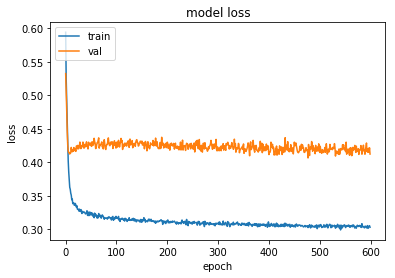

In [11]:
import matplotlib.pyplot as plt
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.savefig("/home/spokencall/dnnPaper/expValidation2/loss.png")
plt.show()

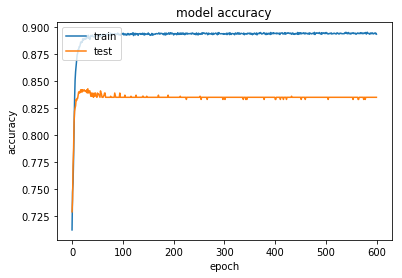

In [12]:
# summarize history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("/home/spokencall/dnnPaper/expValidation2/accuracy.png")
plt.show()

## Evaluation of the model

### Evaluate model with development test data

In [14]:
dev_y_pred = classifier.predict_classes(scaled_dev_test_x)
evaluate(dev_test_y, dev_y_pred)


INCORRECT UTTERANCES (726)
CorrectReject    628
GrossFalseAccept 21*3.0 = 63.0
PlainFalseAccept 77
RejectionRate    0.818

CORRECT UTTERANCES (1798)
CorrectAccept    1631
FalseReject      167
RejectionRate    0.093

--------------REPORT---------------
-----------------------------------
Pr                            0.921
F                             0.914
Sa                            0.907

--------------Metrics--------------
D                             8.804
Da                            4.976
Df                            6.619


### Evaluate model with st2 test_data

In [15]:
st2_y_pred = classifier.predict_classes(scaled_st2_test_x)
evaluate(st2_test_y, st2_y_pred)


INCORRECT UTTERANCES (250)
CorrectReject    222
GrossFalseAccept 1*3.0 = 3.0
PlainFalseAccept 27
RejectionRate    0.881

CORRECT UTTERANCES (750)
CorrectAccept    696
FalseReject      54
RejectionRate    0.072

--------------REPORT---------------
-----------------------------------
Pr                            0.959
F                             0.943
Sa                            0.928

--------------Metrics--------------
D                             12.235
Da                            7.795
Df                            9.766
